In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from random import sample
from scipy.spatial.distance import pdist

In [2]:
cells = pd.read_csv('data/cells_no_repeats.csv', index_col=[0])
all_synapses = pd.read_csv('data/synapses_w_ids.csv', index_col=[0])
print(cells.shape)
print(all_synapses.shape)

(56209, 5)
(5421809, 18)


In [3]:
all_synapses.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'size', 'cell_type_pre',
       'cb_x_pre', 'cb_y_pre', 'cb_z_pre', 'cell_type_post', 'cb_x_post',
       'cb_y_post', 'cb_z_post', 'cb_x_diff', 'cb_y_diff', 'cb_z_diff',
       'ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z', 'synapse_id'],
      dtype='object')

In [4]:
# Remove synapses with the same pre and post cell
all_synapses = all_synapses[all_synapses['pre_pt_root_id'] != all_synapses['post_pt_root_id']]
print(all_synapses.shape)

(4788051, 18)


In [5]:
synapses_by_post = all_synapses.groupby('post_pt_root_id')
print(synapses_by_post.size().shape)

(55895,)


In [28]:
# Ready to go, start with gathering clusters for 3 and 4 using new density estimation, then start from scratch with 5 and 6
k = 3

In [29]:
# Generate local density estimations for each post-synaptic cell
print(f'Sampling density for k={k}')
density_samples = []
for i, (post_id, synapses) in enumerate(synapses_by_post):
    print(synapses.shape)
    if len(synapses) >= k:
        kd_tree = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(
                                            synapses[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']])

        df_to_kd_dict = {}
        kd_to_df_dict = {}
        
        # Create a dictionary to map from kd_tree indices to dataframe indices
        df_index_list = synapses.index.tolist()
        for j, index in enumerate(df_index_list):
            kd_to_df_dict[j] = index
            df_to_kd_dict[index] = j
        
        valid_df_indices = set(df_index_list)
        all_distances, all_kd_indices = kd_tree.kneighbors(synapses[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']])

        while(len(valid_df_indices) > 0):
            df_cntr_pt_id = sample(valid_df_indices, 1)
            cntr_pt = synapses.loc[df_cntr_pt_id]

            kd_cntr_index = df_to_kd_dict[cntr_pt.index[0]]
            distances, kd_indices = all_distances[kd_cntr_index], all_kd_indices[kd_cntr_index]
            
            cluster_points = synapses.iloc[kd_indices]
            dist_pairwise = pdist(cluster_points[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']].to_numpy())
            density_samples.append(k / max(dist_pairwise))

            valid_df_indices -= set([kd_to_df_dict[index] for index in kd_indices])
    # elif len(synapses) > 1:
    #     cluster_points = synapses[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']].to_numpy()
    #     dist_pairwise = pdist(cluster_points)
    #     density_samples.append(len(cluster_points) / max(dist_pairwise))
    print(f'Finished {i} of {len(synapses_by_post)}')
print('Done')

Sampling density for k=3
(1, 18)
Finished 0 of 55895
(78, 18)
Finished 1 of 55895
(69, 18)
Finished 2 of 55895
(43, 18)
Finished 3 of 55895
(155, 18)
Finished 4 of 55895
(36, 18)
Finished 5 of 55895
(94, 18)
Finished 6 of 55895
(126, 18)
Finished 7 of 55895
(111, 18)
Finished 8 of 55895
(220, 18)
Finished 9 of 55895
(24, 18)
Finished 10 of 55895
(172, 18)
Finished 11 of 55895
(85, 18)
Finished 12 of 55895
(82, 18)
Finished 13 of 55895
(132, 18)
Finished 14 of 55895
(81, 18)
Finished 15 of 55895
(110, 18)
Finished 16 of 55895
(71, 18)
Finished 17 of 55895
(16, 18)
Finished 18 of 55895
(14, 18)
Finished 19 of 55895
(38, 18)
Finished 20 of 55895
(73, 18)
Finished 21 of 55895
(63, 18)
Finished 22 of 55895
(56, 18)
Finished 23 of 55895
(84, 18)
Finished 24 of 55895
(167, 18)
Finished 25 of 55895
(20, 18)
Finished 26 of 55895
(22, 18)
Finished 27 of 55895
(127, 18)
Finished 28 of 55895
(107, 18)
Finished 29 of 55895
(76, 18)
Finished 30 of 55895
(162, 18)
Finished 31 of 55895
(118, 18)
Finis

In [30]:
print(len(density_samples))

2212000


In [31]:
pd.to_pickle(density_samples, f'data/synapse_clusters/density_samples_k{k}.pkl')

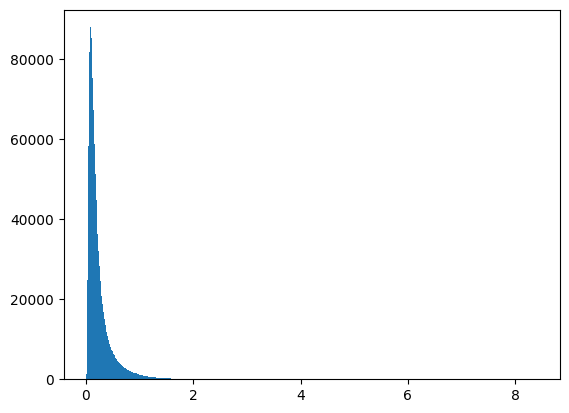

In [32]:
values, bins, _ = plt.hist(density_samples, bins=1000)

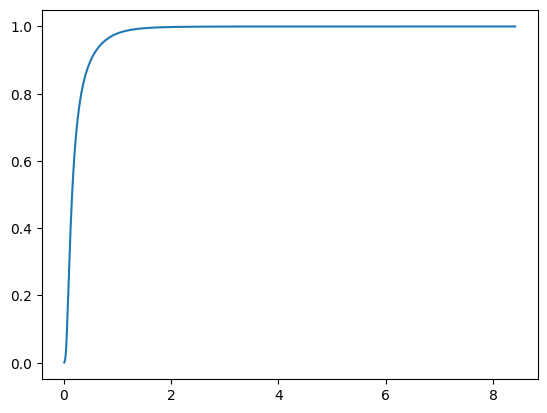

In [33]:
# Plot the cumulative disribution function of the kth_distance
plt.plot(bins[1:], np.cumsum(values) / np.sum(values))
plt.show()

In [34]:
percentile_cutoff = 0.95
density_cutoff = np.percentile(density_samples, percentile_cutoff * 100)
print(density_cutoff)

0.7161785861617342


In [35]:
# Identify the denstiy clusters for each neuron
print(f'Identifying clusters for k={k}')
excluded_synapses = []
clusters = pd.DataFrame(columns=[f'synapse_id_{i}' for i in range(k)] + ['density_score', 'post_pt_root_id'])
type_map = {col: int for col in clusters.columns}
type_map['density_score'] = float
for i, (post_id, synapses) in enumerate(synapses_by_post):
    print(synapses.shape)
    if len(synapses) >= k:
        kd_tree = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(
                                            synapses[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']])
        
        df_to_kd_dict = {}
        kd_to_df_dict = {}
        
        # Create a dictionary to map from kd_tree indices to dataframe indices
        df_index_list = synapses.index.tolist()
        for j, index in enumerate(df_index_list):
            kd_to_df_dict[j] = index
            df_to_kd_dict[index] = j
        
        valid_df_indices = set(df_index_list)
        all_distances, all_kd_indices = kd_tree.kneighbors(synapses[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']])

        while(len(valid_df_indices) > 0):
            df_cntr_pt_id = sample(valid_df_indices, 1)
            cntr_pt = synapses.loc[df_cntr_pt_id]

            kd_cntr_index = df_to_kd_dict[cntr_pt.index[0]]
            distances, kd_indices = all_distances[kd_cntr_index], all_kd_indices[kd_cntr_index]
            
            cluster_points = synapses.iloc[kd_indices]
            dist_pairwise = pdist(cluster_points[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']].to_numpy())
            density_score = k / max(dist_pairwise)

            if density_score >= density_cutoff:
                new_values = cluster_points['synapse_id'].tolist() + [density_score, post_id]
                new_cluster = {col: val for col, val in zip(clusters.columns, new_values)}
                clusters = pd.concat([clusters, pd.DataFrame(new_cluster, index=[0])], ignore_index=True)

            valid_df_indices -= set([kd_to_df_dict[index] for index in kd_indices])
    # elif len(synapses) < k and len(synapses) > 1:
        # dist_pairwise = pdist(synapses[['ctr_pt_x', 'ctr_pt_y', 'ctr_pt_z']].to_numpy())
        # density_score = k / max(dist_pairwise)

        # if density_score >= density_cutoff:
        #     cluster_pop = len(synapses)
        #     k_neighbors = synapses['synapse_id'].tolist()
        #     for l in range(k - cluster_pop):
        #         k_neighbors.append(pd.NA)

        #     new_values = k_neighbors + [density_score, post_id]
        #     new_cluster = {col: val for col, val in zip(clusters.columns, new_values)}
        #     clusters = pd.concat([clusters, pd.DataFrame(new_cluster, index=[0])], ignore_index=True)
    else:
        for synapse_id in synapses['synapse_id'].tolist():
            excluded_synapses.append(synapse_id)
    print(f'Finished {i} of {len(synapses_by_post)}')
print('Done')

Identifying clusters for k=3
(1, 18)
Finished 0 of 55895
(78, 18)
Finished 1 of 55895
(69, 18)
Finished 2 of 55895
(43, 18)
Finished 3 of 55895
(155, 18)
Finished 4 of 55895
(36, 18)
Finished 5 of 55895
(94, 18)
Finished 6 of 55895
(126, 18)
Finished 7 of 55895
(111, 18)
Finished 8 of 55895
(220, 18)
Finished 9 of 55895
(24, 18)
Finished 10 of 55895
(172, 18)
Finished 11 of 55895
(85, 18)
Finished 12 of 55895
(82, 18)
Finished 13 of 55895
(132, 18)
Finished 14 of 55895
(81, 18)
Finished 15 of 55895
(110, 18)
Finished 16 of 55895
(71, 18)
Finished 17 of 55895
(16, 18)
Finished 18 of 55895
(14, 18)
Finished 19 of 55895
(38, 18)
Finished 20 of 55895
(73, 18)
Finished 21 of 55895
(63, 18)
Finished 22 of 55895
(56, 18)
Finished 23 of 55895
(84, 18)
Finished 24 of 55895
(167, 18)
Finished 25 of 55895
(20, 18)
Finished 26 of 55895
(22, 18)
Finished 27 of 55895
(127, 18)
Finished 28 of 55895
(107, 18)
Finished 29 of 55895
(76, 18)
Finished 30 of 55895
(162, 18)
Finished 31 of 55895
(118, 18)
F

In [36]:
print(clusters.shape)
print(len(excluded_synapses))

(110784, 5)
589


In [37]:
clusters.to_csv(f'data/synapse_clusters/clusters_k{k}.csv', index=False)